In [1]:
%matplotlib inline
import fiona
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

## Regression practice dataset

### City of Miami public safety data

I've recently created a dataset for those who are interested in learning spatial regression techniques. 

Over time I'd like to create some short walkthrough guides using this dataset to apply different techniques (using Python, RTMDx, QGIS and GeoDA), but for now I'm just sharing the dataset.

The City of Miami Police Department crime data has been scraped from https://www.crimemapping.com/ over the past two-years. Data on points of interest, administrative boundaries and environmental crime (from 311 reports) has been extracted from various datasets held on the City of Miami (https://data.miamigov.com/) and Miami-Dade County (https://gis-mdc.opendata.arcgis.com/) open data websites.

#### Voronoi polygon for Miami

Additionally I have created a Voronoi Polygon layer for the City of Miami as an alternative to using city Blocks or other micro-level administrative boundaries. The reason I have done this is because lines drawn at city blocks dissect crime hotspots, such as where crimes take place on opposite sides of the same street or intersection. Voronoi polygons are offset from street intersections to avoid this. 

The images below provide a visual example of the difference.

Text(0.5, 1.0, 'Voronoi Polygons')

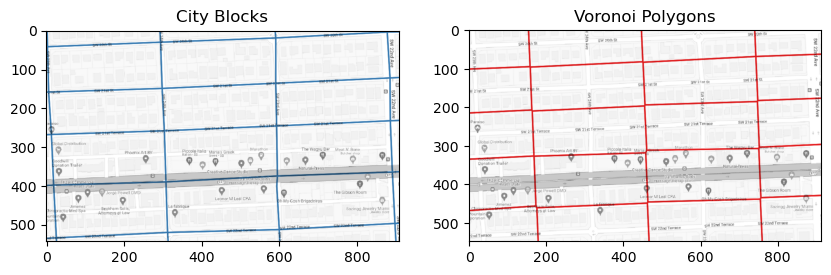

In [2]:
img1 = plt.imread('blocks_layer.png')
img2 = plt.imread('voronoi_layer.png')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img1)
ax1.set_title('City Blocks')
ax2.imshow(img2)
ax2.set_title('Voronoi Polygons')

#### If you have specific queries on any of the sources or how I've put this together, please feel free to ask.

### 1. Preparing the data for spatial regression

The dataset for this notebook can be downloaded from the following DropBox URL:

https://www.dropbox.com/s/989k5q0mwls3v2t/com_police_data.gpkg?dl=0

There are 9 datasets in total within the GeoPackage. All geographical data has a Coordinate Reference System of EPSG:3511 (Florida East, metres). If you're more comfortable working with ft rather than metres then these would need to be set as EPSG:2236.

Point layers:

1. Burglary data
2. Environmental crime 2021
3. Environmental crime 2022
4. Violent crime, including aggravated assault, simple assault, homicide, robbery and weapons
5. Voronoi polygon layer centroids

Polygon layers:

6. Miami Police Districts
7. Neighbourhood boundaries
8. Voronoi polygon layer

Data table:

9. Data aggregated to voronoi polygons

In this notebook we will only be working with 6/8/9.

In [3]:
# View layers in gpkg
fiona.listlayers('com_police_data.gpkg')

['com_burg_epsg3511',
 'com_nhoods',
 'com_violent_crime_2021_22',
 'com_voronoi_points',
 'com_voronoi_polygons',
 'com311_env_crime2021',
 'com311_env_crime2022',
 'mpd_districts',
 'com_police_data',
 'layer_styles',
 'com_aggregated_data']

The voronoi polygon and points datasets do not contain any variables. You will need to open them up and join them to the aggregated table data (`com_aggregated_data`). 

These steps are shown below with the voronoi polygon layer (`com_voronoi_polygons`).

In [4]:
# Read in voronoi polygon layer
v_poly = gpd.read_file('com_police_data.gpkg', layer='com_voronoi_polygons')
v_poly.head()

,geometry
0,"MULTIPOLYGON (((275131.444 152577.408, 275187...."
1,"MULTIPOLYGON (((274305.743 152541.537, 274239...."
2,"MULTIPOLYGON (((274400.256 152547.313, 274408...."
3,"MULTIPOLYGON (((274737.717 152563.557, 274767...."
4,"MULTIPOLYGON (((274126.975 152562.154, 274121...."


In [5]:
# Read in the aggregated table data and drop the empty geometry column it contains
data = gpd.read_file('com_police_data.gpkg', layer='com_aggregated_data')
data.drop(columns='geometry', inplace=True)
data.head(2)

,census_tract,tract_population,tract_pop_sqmi,tract_area_sqmi,neighbourhood,police_district,agg_ass21,agg_ass22,res_burg21,res_burg22,...,agg_ass21lnsq,agg_ass22lnsq,res_burg21lnsq,res_burg22lnsq,rob21lnsq,rob22lnsq,simp_ass21lnsq,simp_ass22lnsq,weap21lnsq,weap22lnsq
0,7300.0,4248.0,3792.9,1.12,None,None,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7300.0,4248.0,3792.9,1.12,None,None,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Perform a join of the voronoi polygon (or point) and the table data
v_poly_data = pd.merge(v_poly, data, how='inner', left_index=True, right_index=True)
v_poly_data.head(2)

,geometry,census_tract,tract_population,tract_pop_sqmi,tract_area_sqmi,neighbourhood,police_district,agg_ass21,agg_ass22,res_burg21,...,agg_ass21lnsq,agg_ass22lnsq,res_burg21lnsq,res_burg22lnsq,rob21lnsq,rob22lnsq,simp_ass21lnsq,simp_ass22lnsq,weap21lnsq,weap22lnsq
0,"MULTIPOLYGON (((275131.444 152577.408, 275187....",7300.0,4248.0,3792.9,1.12,None,None,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"MULTIPOLYGON (((274305.743 152541.537, 274239....",7300.0,4248.0,3792.9,1.12,None,None,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# view the columns present
print(v_poly_data.columns)

Index(['geometry', 'census_tract', 'tract_population', 'tract_pop_sqmi',
       'tract_area_sqmi', 'neighbourhood', 'police_district', 'agg_ass21',
       'agg_ass22', 'res_burg21', 'res_burg22', 'rob21', 'rob22', 'simp_ass21',
       'simp_ass22', 'weap21', 'weap22', 'dist_bank', 'dist_barbershop',
       'dist_bars', 'dist_busstop', 'dist_carwash', 'dist_laundrette',
       'dist_college', 'dist_convenience', 'dist_drug_store', 'dist_ent_venue',
       'dist_gas_stn', 'dist_hotel_motel', 'dist_liqor', 'dist_major_mall',
       'dist_metrorail', 'dist_park', 'dist_restaurant', 'dist_supermarket',
       'dens_banks', 'dens_bars', 'dens_laundrette', 'dens_convenience',
       'dens_drug_store', 'dens_gas_stn', 'dens_hotels', 'dens_liqor',
       'dens_restaurants', 'dist450m_bank', 'dist450m_barbershop',
       'dist450m_bars', 'dist450m_busstop', 'dist450m_carwash',
       'dist450m_laundrette', 'dist450m_college', 'dist450m_convenience',
       'dist450m_drug_store', 'dist450m_ent_ve

There are almost 100 variables in the dataset. Some are self-explanatory, such as the police district, neighbourhood or tract that the voronoi point/polygon belongs to. The others I have grouped below together to be explored later in the notebook.

They are as follows:

- `bin_data`, or binary data. These variables denote whether or not the voronoi polygon centroid is within a specified distance of a particular point of interest. For example, dist450m_bars represents whether or not the location has a bar within 450m - 1 for yes or 0 for no. Similarly, this is done for density of points of interest. If the density of bars is more than 1 standard deviation above the mean (dens1SD_bars) then it is 1 for yes or 0 for no.



In [8]:
bin_data = [
    'dist450m_bank', 
    'dist450m_barbershop',
    'dist450m_bars', 
    'dist450m_busstop', 
    'dist450m_carwash',
    'dist450m_laundrette',
    'dist450m_college', 
    'dist450m_convenience',
    'dist450m_drug_store', 
    'dist450m_ent_venue', 
    'dist450m_gas_stn',
    'dist450m_hotel_motel', 
    'dist450m_liqor', 
    'dist450m_major_mall',
    'dist450m_metrorail', 
    'dist450m_park', 
    'dist450m_restaurant',
    'dist450m_supermarket', 
    'dens1SD_banks', 
    'dens1SD_bars',
    'dens1SD_laundrette', 
    'dens1SD_convenience', 
    'dens1SD_drug_store',
    'dens1SD_gas_stn', 
    'dens1SD_hotels', 
    'dens1SD_liqor',
    'dens1SD_restaurants'
]

- `crime_counts`. These variables show the number of crimes occurring within each voronoi polygon. They include data for comparative periods in 2021 and 2022 for each type of crime. Crime types included are aggravated assault, simple assault, robbery, household burglary and weapon crimes.

In [9]:
crime_counts = [
    'agg_ass21',
    'agg_ass22', 
    'res_burg21', 
    'res_burg22', 
    'rob21', 
    'rob22', 
    'simp_ass21',
    'simp_ass22', 
    'weap21', 
    'weap22'
]

- `crime_logs`. These variables are a transformation of the crime counts, the logarithim of the crime count sqrt. These are here as an example and for convenience, but users of the dataset may wish to apply their own data transformations. There is a helpful resource here which details various methods and considerations for data transformations https://online.stat.psu.edu/stat462/node/155/

In [10]:
crime_logs = [
    'agg_ass21lnsq', 
    'agg_ass22lnsq',
    'res_burg21lnsq', 
    'res_burg22lnsq',
    'rob21lnsq', 
    'rob22lnsq',
    'simp_ass21lnsq', 
    'simp_ass22lnsq', 
    'weap21lnsq', 
    'weap22lnsq'
]

- `risk_settings_density`. These variables provide the value of a KDE (Hotspot) plot where it overlaps the voronoi. The higher the density of a point of interest, the higher the value. The density layers for each point of interest are based on a search radius of 450m.

In [11]:
risk_settings_density = [
    'dens_banks', 
    'dens_bars', 
    'dens_laundrette', 
    'dens_convenience',
    'dens_drug_store', 
    'dens_gas_stn', 
    'dens_hotels', 
    'dens_liqor',
    'dens_restaurants'
]

- `risk_settings_distance`. These variables provide the inverse distance in metres from the point of interest to the voronoi polygon centroid. The actual distance in metres between the voronoi polygon centroids and its nearest point of interest is also present in the dataset.

In [12]:
risk_settings_distance = [
    'invdist_bars',  
    'invdist_carwash', 
    'invdist_laundrette',
    'invdist_convenience', 
    'invdist_drug_store', 
    'invdist_ent_venue',
    'invdist_gas_stn', 
    'invdist_hotel_motel',
    'invdist_liqor', 
    'invdist_metrorail', 
    'invdist_restaurant',
    'invdist_supermarket'
]

Finally, we will open the City of Miami Police Districts layer

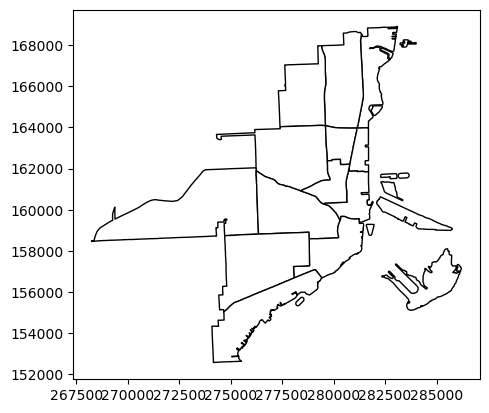

In [13]:
mpd_dist = gpd.read_file('com_police_data.gpkg', layer='mpd_districts')
mpd_dist.plot(fc='White', ec='Black');

### 2. Visualising the dataset

To provide a better idea of what the dataset looks like, I have plotted each group of variables created previously. 

The first plot below shows the `risk_settings_density` layers. We can see from this where different risk settings cluster together, using Banks, Bars, Laundrettes and so on.

We might wish to think about which of these risk settings might contribute to the presence of a crime problem, or help explain why a crime problem concentrates in a particlar geographic location.

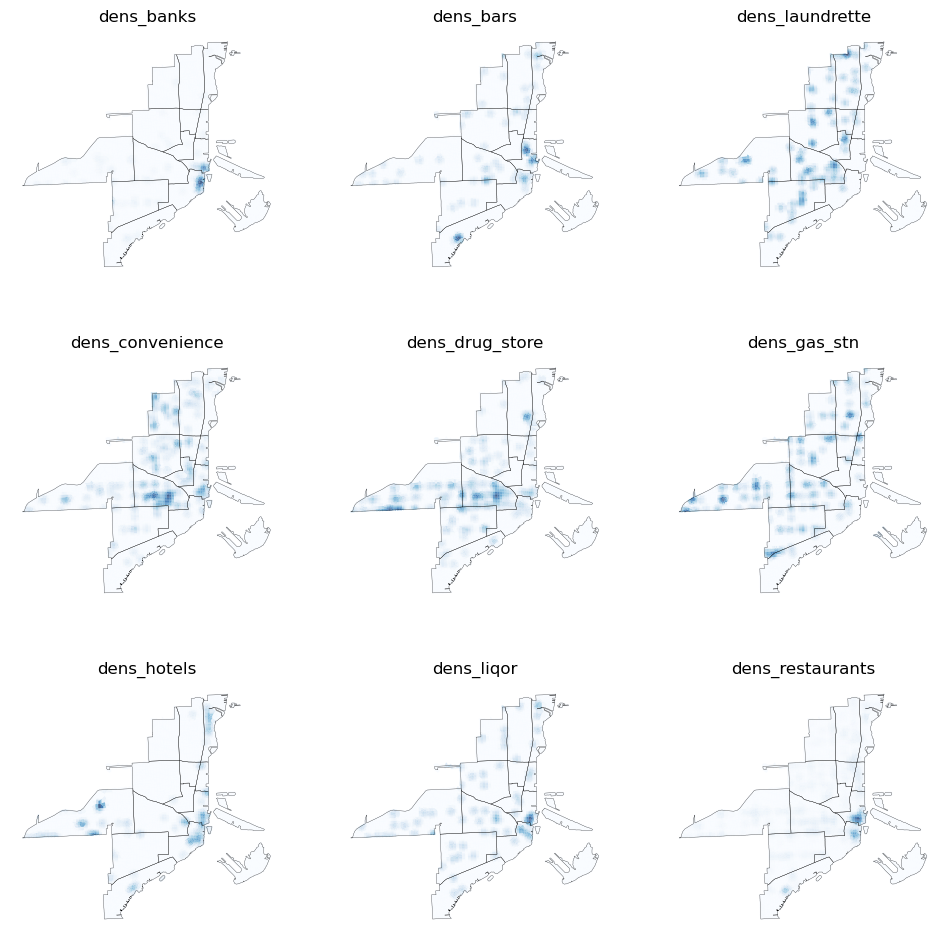

In [14]:
# Create figure and axes (9 vars, 3x3)
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the variables of interest
for i, col in enumerate(risk_settings_density):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    v_poly_data.plot(
        column=col, 
        ax=ax, 
        linewidth=0, 
        cmap='Blues', 
        alpha=0.75
    )
    # Add Miami PD boundaries
    mpd_dist.plot(fc='none', 
                  ec='Black',
                  linewidth=.2,
                  ax=ax)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show();

The second plot below shows the `risk_settings_distance` variables. Darker shaded polygons are closer to each point of interest, and lighter shaded polygons are further away.

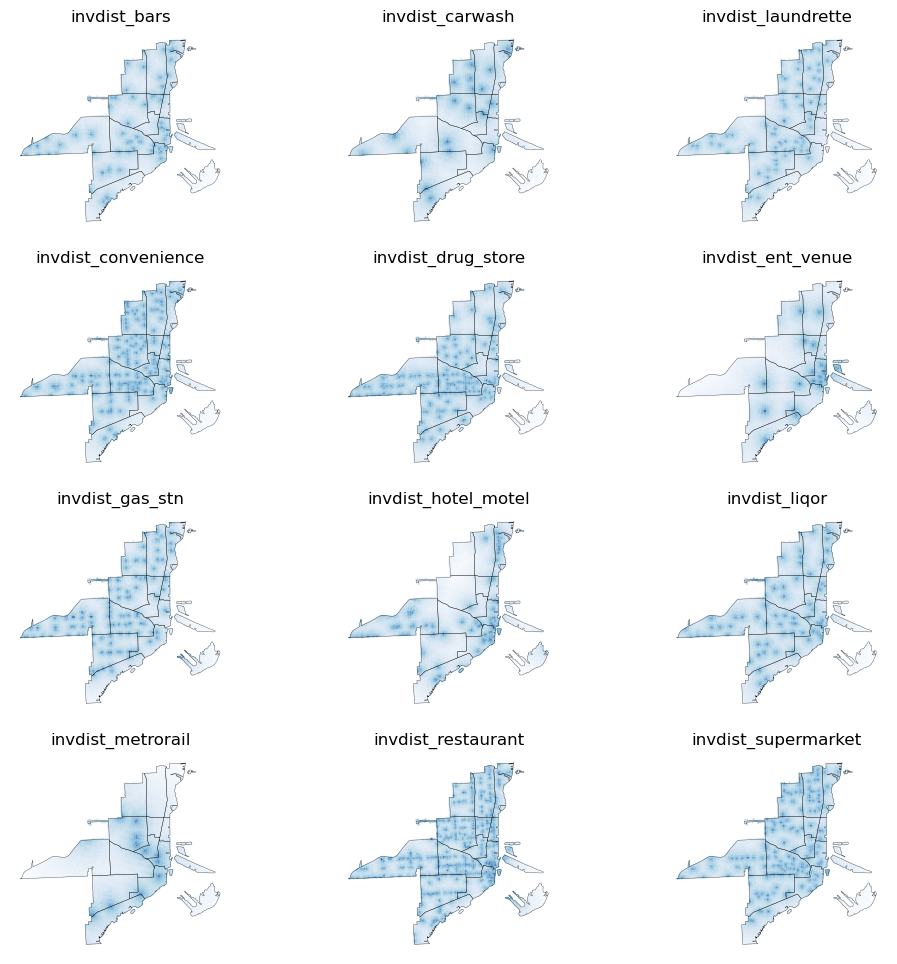

In [15]:
f, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))
axs = axs.flatten()
for i, col in enumerate(risk_settings_distance):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    v_poly_data.plot(
        column=col, 
        ax=ax, 
        linewidth=0, 
        cmap='Blues', 
        alpha=0.75
    )    
    mpd_dist.plot(fc='none', 
                  ec='Black',
                  linewidth=.2,
                  ax=ax)    
    ax.set_axis_off()    
    ax.set_title(col)
plt.show();

The third plot below shows the distribution of crime using `crime_logs` variables, for each crime type and year.

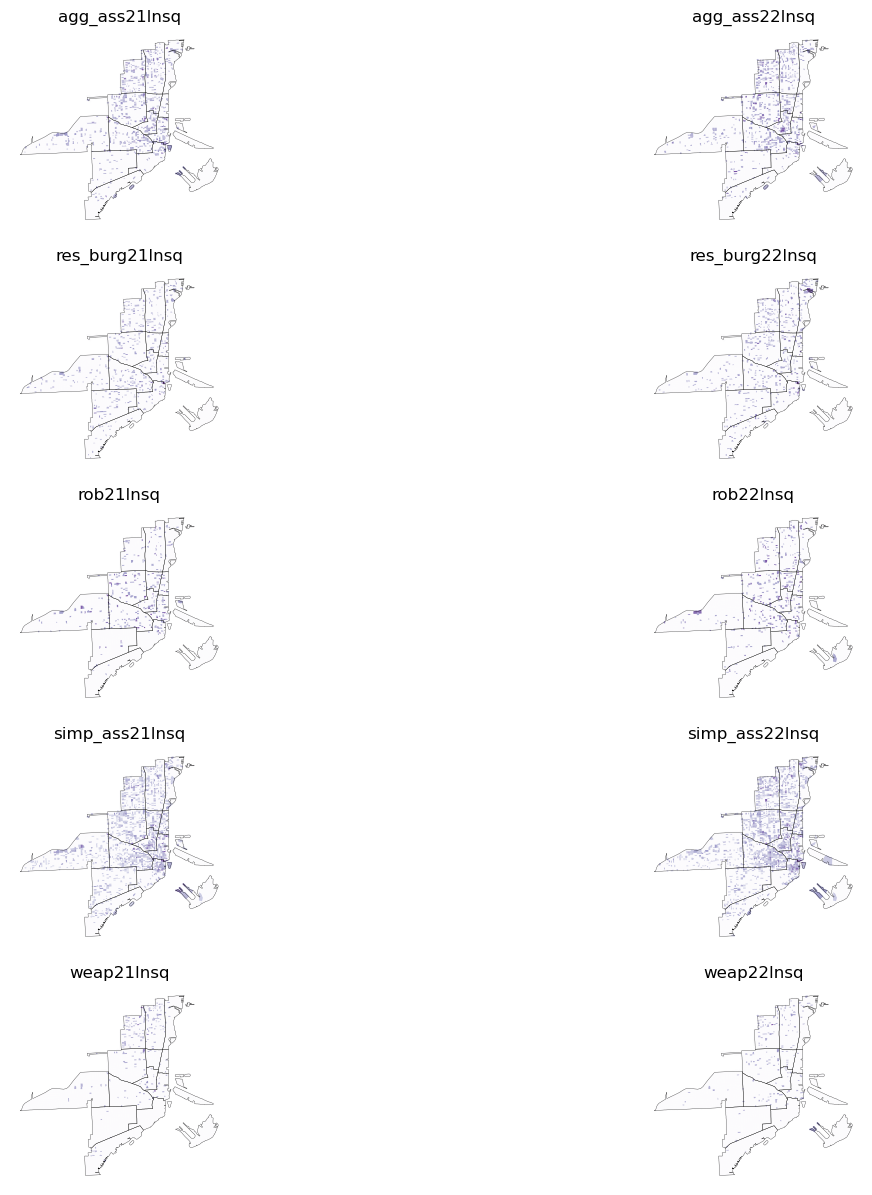

In [16]:
f, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
axs = axs.flatten()
for i, col in enumerate(crime_logs):
    ax = axs[i]
    v_poly_data.plot(
        column=col, 
        ax=ax, 
        linewidth=0, 
        cmap='Purples', 
        alpha=0.75
    )
    mpd_dist.plot(fc='none', 
                  ec='Black',
                  linewidth=.2,
                  ax=ax)
    ax.set_axis_off()
    ax.set_title(col)
plt.show()

The fourth and final plot below shows the `bin_data`, displaying each voronoi polygon that is either within 450m of or has a high density of a particular point of interest and potential risk setting for crime.

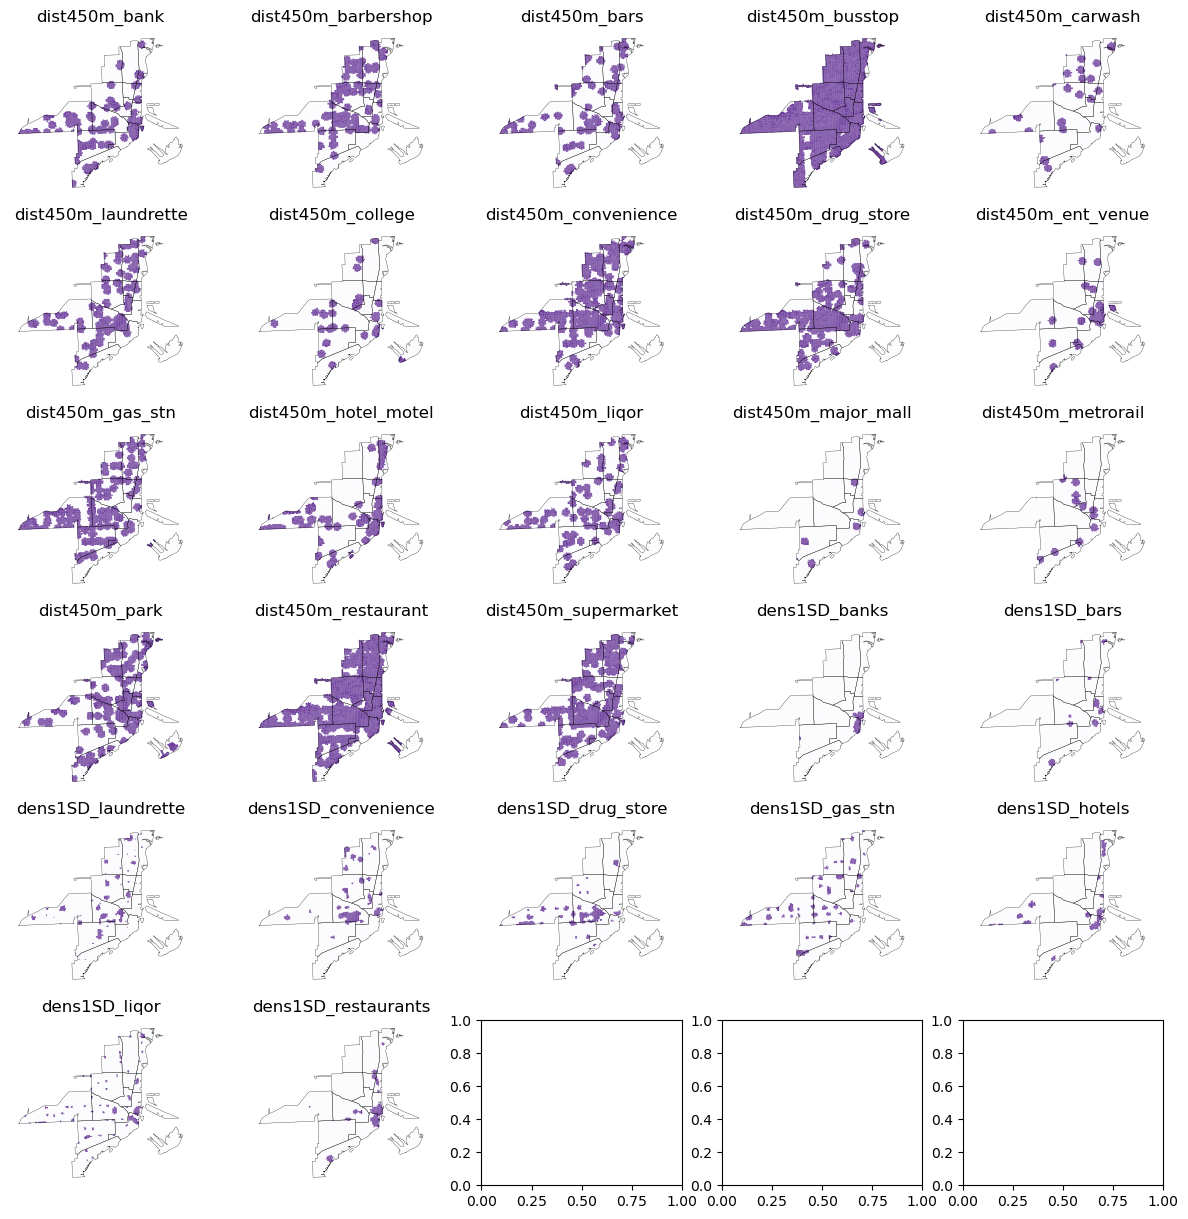

In [17]:
f, axs = plt.subplots(nrows=6, ncols=5, figsize=(15, 15))
axs = axs.flatten()
for i, col in enumerate(bin_data):
    ax = axs[i]
    v_poly_data.plot(
        column=col, 
        ax=ax, 
        linewidth=0, 
        cmap='Purples', 
        alpha=0.75
    )
    mpd_dist.plot(fc='none', 
                  ec='Black',
                  linewidth=.2,
                  ax=ax)
    ax.set_axis_off()
    ax.set_title(col)
plt.show()

We can also visualise these variables using non-spatial methods, see for example a correlation plot of a selection of variables. We can observe here the relationship between simple assaults in 2021 and 2022 against a handful of points of interests. We can also see if there are correlations in the location of points of interest (i.e. locations of liqor stores and restaurants have the highest positive correlation among points of interest, albeit weak). 

In [18]:
corr = v_poly_data[['dens_bars', 
                   'invdist_ent_venue',
                   'dens_hotels',
                   'invdist_metrorail',
                   'invdist_restaurant',
                   'invdist_liqor',
                   'simp_ass21',
                   'simp_ass22'
                   ]].corr().round(3)

corr.style.background_gradient(cmap='coolwarm', 
                               low=0, 
                               high=0, 
                               axis=None, 
                               subset=None, 
                               vmax=None)

,dens_bars,invdist_ent_venue,dens_hotels,invdist_metrorail,invdist_restaurant,invdist_liqor,simp_ass21,simp_ass22
dens_bars,1.000000,0.186000,0.240000,0.072000,0.283000,0.213000,0.156000,0.141000
invdist_ent_venue,0.186000,1.000000,0.087000,0.318000,0.241000,0.151000,0.166000,0.142000
dens_hotels,0.240000,0.087000,1.000000,0.013000,0.213000,0.205000,0.156000,0.112000
invdist_metrorail,0.072000,0.318000,0.013000,1.000000,0.041000,0.006000,0.104000,0.105000
invdist_restaurant,0.283000,0.241000,0.213000,0.041000,1.000000,0.432000,0.211000,0.210000
invdist_liqor,0.213000,0.151000,0.205000,0.006000,0.432000,1.000000,0.123000,0.149000
simp_ass21,0.156000,0.166000,0.156000,0.104000,0.211000,0.123000,1.000000,0.639000
simp_ass22,0.141000,0.142000,0.112000,0.105000,0.210000,0.149000,0.639000,1.000000


A pairplot can also help us visualise the relationship between our variables

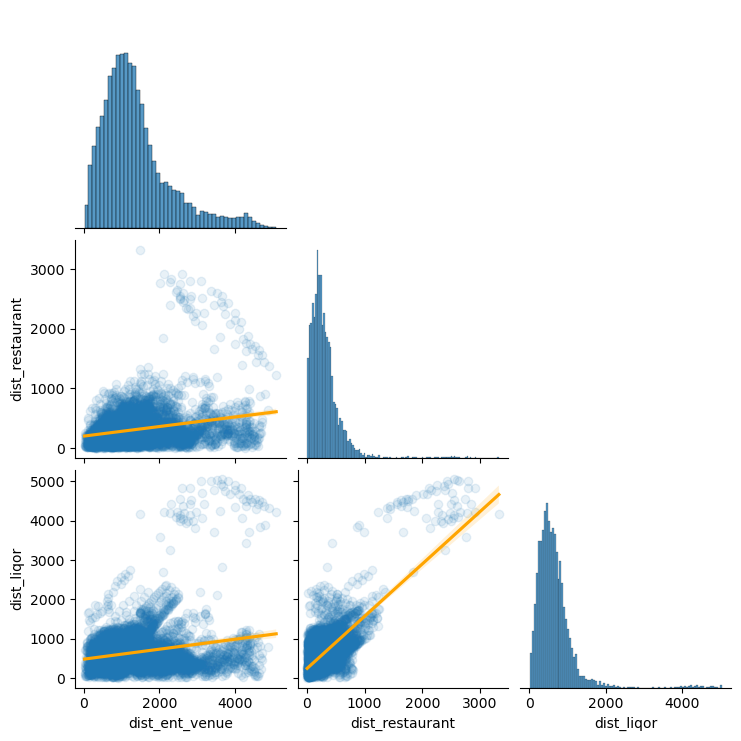

In [19]:
sns.pairplot(vars=['dist_ent_venue',
                   'dist_restaurant',
                   'dist_liqor',
                   ], 
             kind='reg', 
             diag_kind='hist', 
             corner=True,
             plot_kws={'scatter_kws':{'alpha':0.1}, 'line_kws':{'color':'orange'}},
                          data=v_poly_data)